 # Simple clustering of larvae sc-RNAseq (sample_2, rbf)

In [1]:
import numpy as np
import pandas as pd
# import scanpy as sc

from graspologic.embed.ase import AdjacencySpectralEmbed
# from graspologic.embed.lse import LaplacianSpectralEmbed
# from graspologic.embed import select_dimension
# from graspologic.utils import is_symmetric, is_unweighted
from graspologic.utils import symmetrize, is_fully_connected, largest_connected_component
from graspologic.plot import pairplot
from graspologic.cluster import AutoGMMCluster

from sklearn.metrics import adjusted_rand_score, pairwise_kernels
from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import normalize
from sklearn.neighbors import kneighbors_graph
# from sklearn.cluster import SpectralClustering

# from scipy.stats import spearmanr, kendalltau
import os
# from itertools import combinations
# from scipy.io import mmread
import matplotlib.pyplot as plt
import seaborn as sns
import random

context = sns.plotting_context(context="talk", font_scale=0.8)
sns.set_context(context)


 ## import intermediate results from R

In [2]:
sample_id = 's2'
SCT_residuals = pd.read_csv("Brainseq/"+sample_id+"/residuals.csv", index_col=0)
residuals = SCT_residuals.to_numpy()


 ## construct graph adjacency matrix

In [3]:
dist_mat = euclidean_distances(residuals)

# # rescale distances into [0,1] and convert to adjacency matrix
# adj_scale = 1 - dist_mat / dist_mat.max()

# or use a kernel to make adjacency matrix
delta = np.std(dist_mat.flatten()) * 5  # tentatively using 5 after some tuning
adj_rbf = np.exp(- dist_mat ** 2 / (2. * delta ** 2))

# # or try kNN graph
# adj_knn = kneighbors_graph(dist_mat, n_neighbors=15, include_self=True)
# adj_knn = symmetrize(adj_knn.toarray())


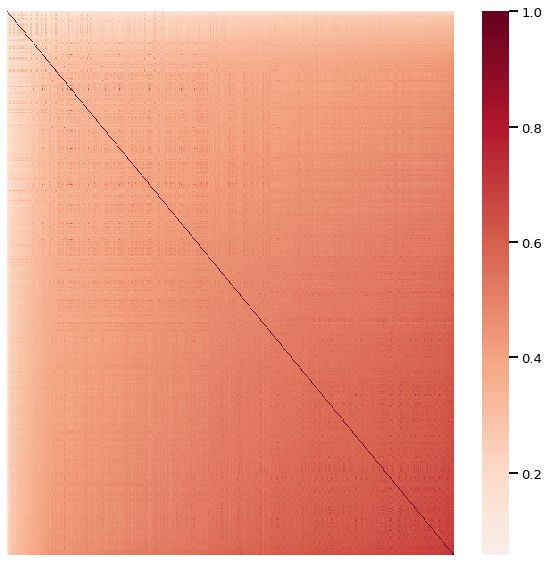

In [15]:
# plot heatmap of the graph (or a random subgraph if graph is too large)

adj = adj_rbf.copy()
idx = np.argsort(np.sum(adj, axis=0))
len_subplot = 500
subset = random.sample(range(len(adj)), len_subplot)
idx = idx[np.sort(subset)]
adj_sorted = adj[idx] [:,idx]
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(adj_sorted, cmap="RdBu_r", center=0, cbar=True, ax=ax, xticklabels='', yticklabels='')
plt.show()


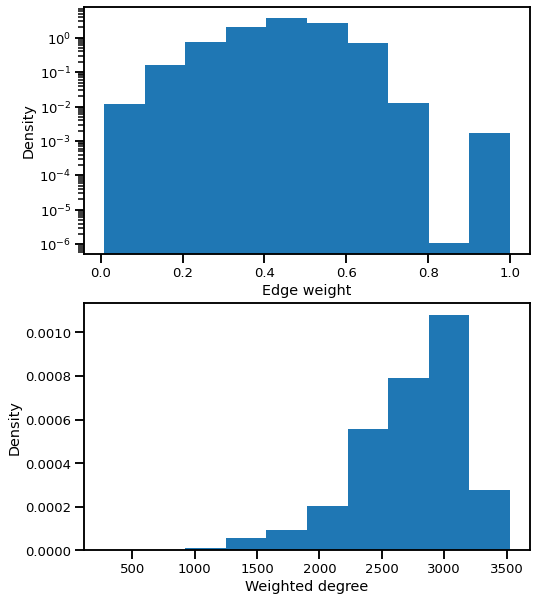

In [5]:
# check if graph is fully connected
if not is_fully_connected(adj):
    adj = largest_connected_component(adj)

fig, axs = plt.subplots(2,1, figsize=(8,10))
ax = axs[0]
ax.hist(adj.flatten(), log=True, density=True)
ax.set(xlabel='Edge weight', ylabel='Density')
ax = axs[1]
ax.hist(np.sum(adj, axis=0), density=True)
ax.set(xlabel='Weighted degree', ylabel='Density')
plt.show()


 ## spectral embedding

/home/tliu68/miniconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:356: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/home/tliu68/miniconda3/lib/python3.8/site-packages/sklearn/utils/extmath.py:356: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


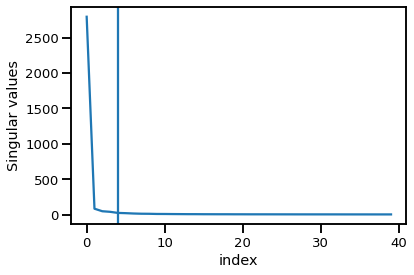

In [6]:
ase = AdjacencySpectralEmbed(40)
ase.fit(adj)
singular_values = ase.singular_values_
fig,ax = plt.subplots(1)
ax.plot(range(len(singular_values)), singular_values)

ase = AdjacencySpectralEmbed(n_elbows=2)
embedding = ase.fit_transform(adj)
ax.axvline(embedding.shape[1])
ax.set(xlabel='index', ylabel='Singular values')
plt.show()


 ## visualize marker genes' expression levels for different cell types on the embeddings

In [7]:
feature_id = {}

feature_names_all = [
    ["brp","nSyb","elav","Syt1","CadN","jeb","IA-2","Rdl","nrv-3","VGlut","VAChT",
     "Gad1","Vmat","jim","myr-GFP-p10","nls-tdTomato"],  # neuron
    ["repo", "hoe1","swim","vir-1","wrapper","alrm","Eaat1","Gat","Gs30","MFS9",
     "bnb","sli"],  # glia
    ["N","dpn","Pen","mira","Grh","Kr"],  # NPCs
    # ["hdc","unk","sn","pho"],  # adult neurons
]
for i in range(len(feature_names_all)):
    feature_id[i] = []
    for j in feature_names_all[i]:
        try:
            feature_id[i].append(SCT_residuals.T.index.get_loc(j))
        except:
            continue
colors = ['Reds', 'Blues', 'Purples']
cell_types = ['neuron', 'glia', 'NPC']
n_dim = embedding.shape[1]


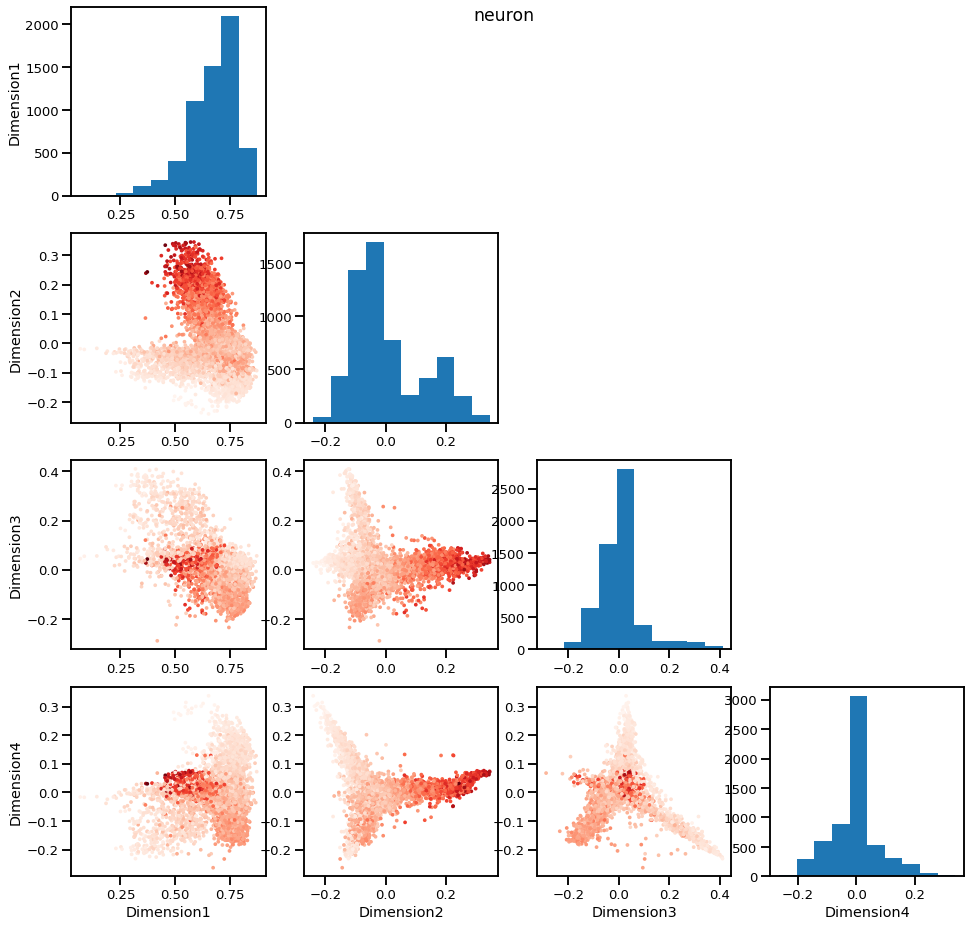

In [8]:
cell_type_id = 0
expn = np.sum(residuals[:,feature_id[cell_type_id]], axis=1)

fig,axs = plt.subplots(n_dim, n_dim,figsize=(n_dim*4, n_dim*4))
for i in range(n_dim):
    for j in range(n_dim):
        ax = axs[i,j]
        if j > i:
            ax.axis('off')
        else:
            if j == i:
                ax.hist(embedding[:,i])
            else:
                ax.scatter(embedding[:,j], embedding[:,i], s=5, cmap=colors[cell_type_id],
                    c=expn)
            if i == n_dim - 1:
                ax.set_xlabel('Dimension'+str(j+1))
            if j == 0:
                ax.set_ylabel('Dimension'+str(i+1))
plt.suptitle(cell_types[cell_type_id], y=0.88)
plt.show()


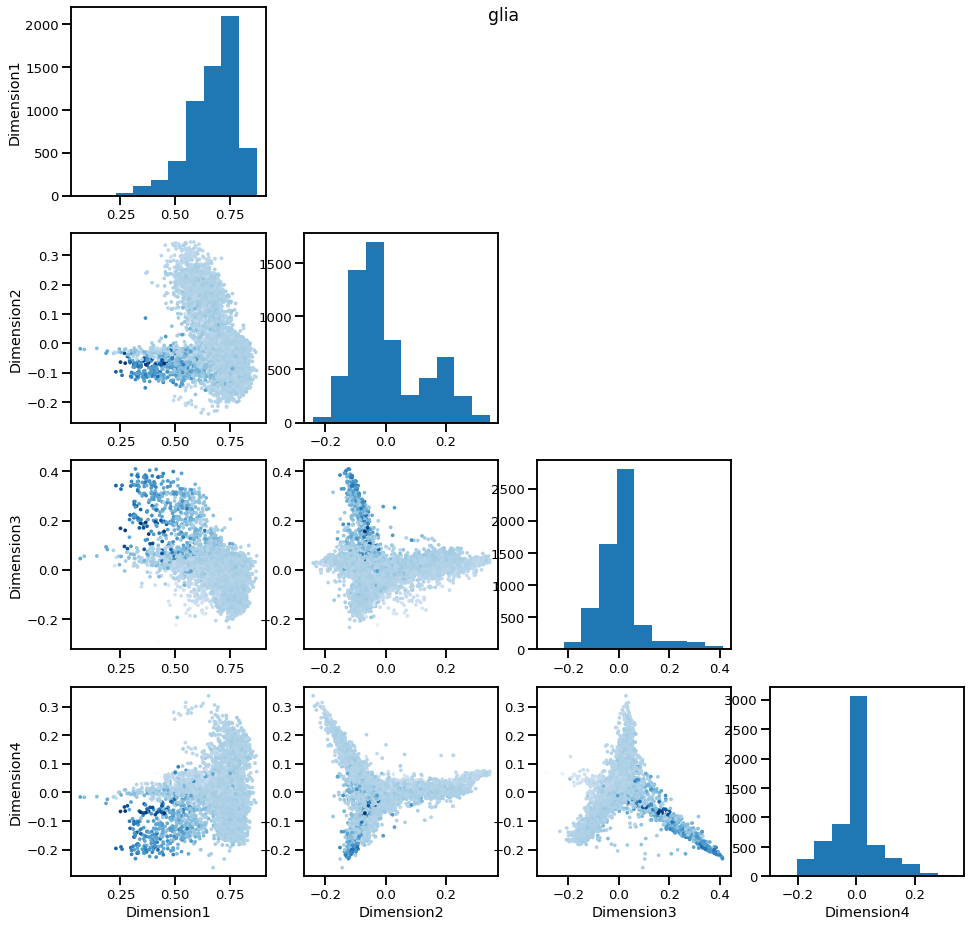

In [9]:
cell_type_id = 1
expn = np.sum(residuals[:,feature_id[cell_type_id]], axis=1)

fig,axs = plt.subplots(n_dim, n_dim,figsize=(n_dim*4, n_dim*4))
for i in range(n_dim):
    for j in range(n_dim):
        ax = axs[i,j]
        if j > i:
            ax.axis('off')
        else:
            if j == i:
                ax.hist(embedding[:,i])
            else:
                ax.scatter(embedding[:,j], embedding[:,i], s=5, cmap=colors[cell_type_id],
                    c=expn)
            if i == n_dim - 1:
                ax.set_xlabel('Dimension'+str(j+1))
            if j == 0:
                ax.set_ylabel('Dimension'+str(i+1))
plt.suptitle(cell_types[cell_type_id], y=0.88)
plt.show()


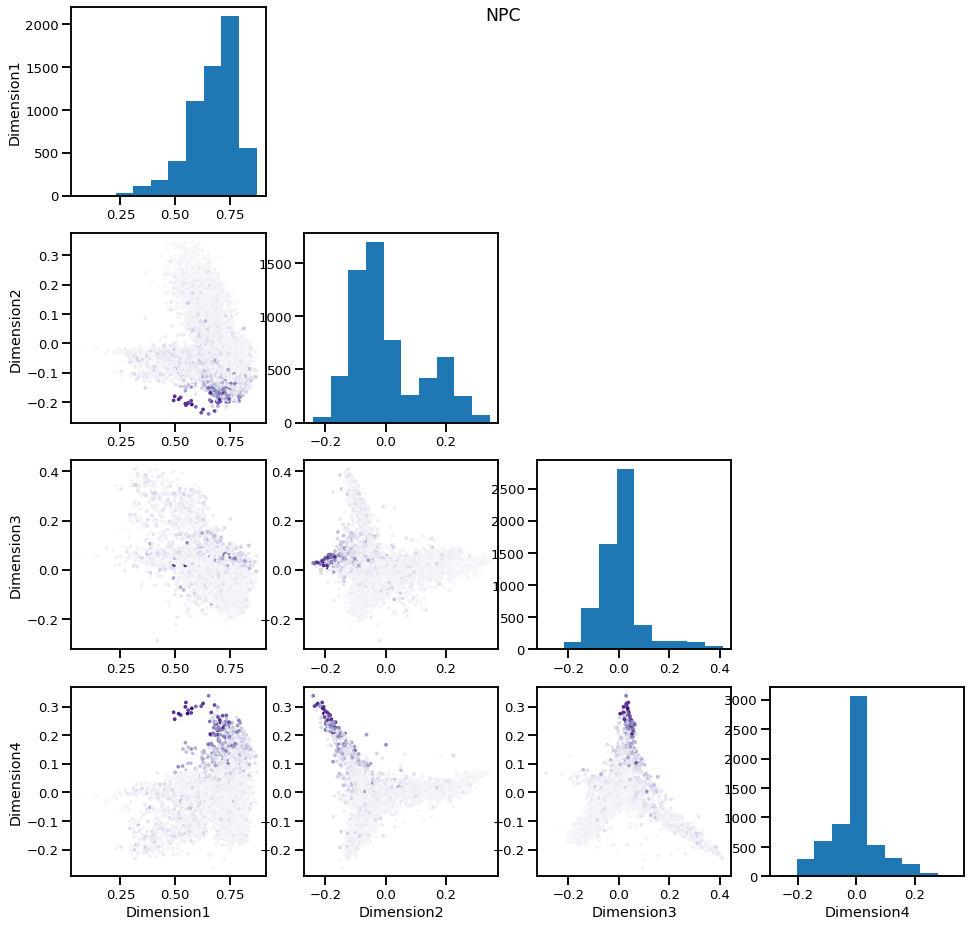

In [10]:
cell_type_id = 2
expn = np.sum(residuals[:,feature_id[cell_type_id]], axis=1)

fig,axs = plt.subplots(n_dim, n_dim,figsize=(n_dim*4, n_dim*4))
for i in range(n_dim):
    for j in range(n_dim):
        ax = axs[i,j]
        if j > i:
            ax.axis('off')
        else:
            if j == i:
                ax.hist(embedding[:,i])
            else:
                ax.scatter(embedding[:,j], embedding[:,i], s=5, cmap=colors[cell_type_id],
                    c=expn)
            if i == n_dim - 1:
                ax.set_xlabel('Dimension'+str(j+1))
            if j == 0:
                ax.set_ylabel('Dimension'+str(i+1))
plt.suptitle(cell_types[cell_type_id], y=0.88)
plt.show()


 ## Automatic Gaussian mixture modeling

In [14]:
n_components = [5, 8, 11, 14, 17, 20]
best_bics = []
for n in n_components:
    agg = AutoGMMCluster(min_components=n, max_components=n, n_jobs=20)
    agg.fit(embedding)
    best_bics.append(agg.criter_)


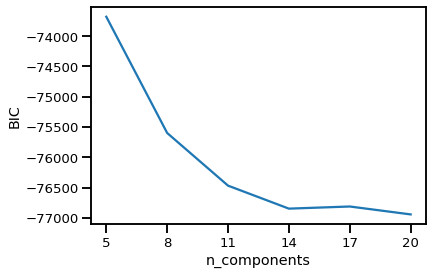

In [15]:
fig, ax = plt.subplots(1)
ax.plot(n_components, best_bics)
ax.set(xlabel='n_components', ylabel='BIC', xticks=n_components)
plt.show()


In [11]:
agg = AutoGMMCluster(min_components=14, max_components=14, n_jobs=20)
pred = agg.fit_predict(embedding)


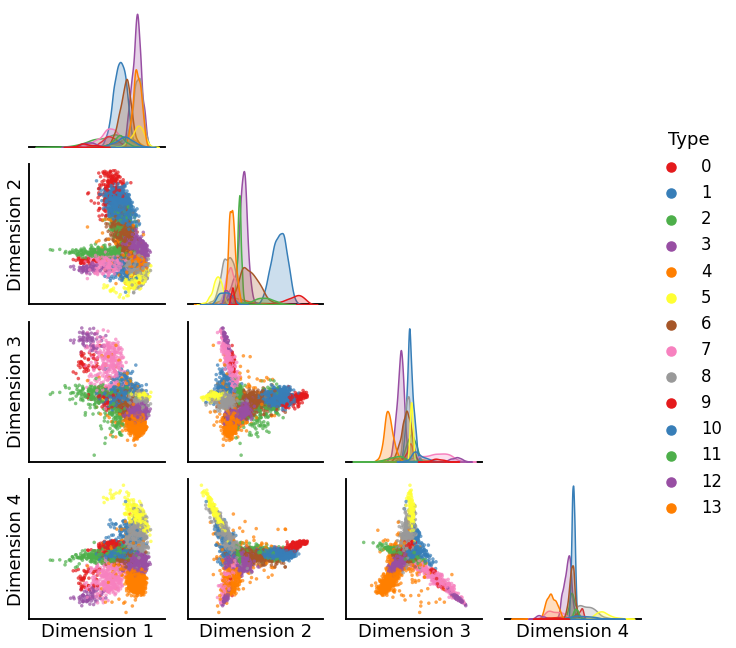

In [12]:
pairplot(embedding, pred)
plt.show()


 ## visualize marker genes' expression levels for different cell types in estimated clusters

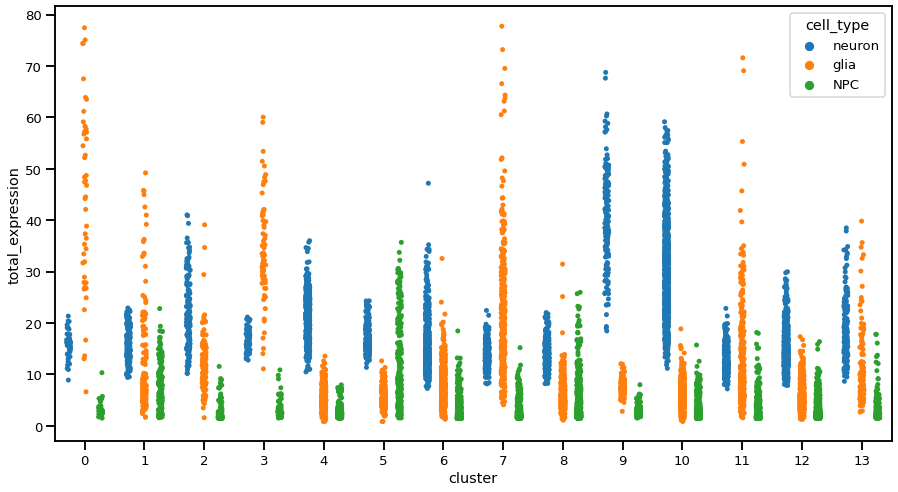

In [13]:
expn_overall = residuals.copy()
expn_all_cell_types = np.vstack((
    np.array(np.sum(np.absolute(expn_overall[:,feature_id[0]]), axis=1)),
    np.array(np.sum(np.absolute(expn_overall[:,feature_id[1]]), axis=1)),
    np.array(np.sum(np.absolute(expn_overall[:,feature_id[2]]), axis=1))
    )).reshape(-1,)

df = pd.DataFrame(data={
    'total_expression': expn_all_cell_types,
    'cluster': np.hstack((pred, pred, pred)),
    'cell_type': np.repeat(['neuron', 'glia', 'NPC'], len(pred))
})

fig,ax = plt.subplots(1, figsize=(15,8))
sns.stripplot(data=df, x='cluster', y='total_expression', hue='cell_type',
    dodge=True, ax=ax)
plt.show()